In [10]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
# import os
# os.environ["PATH"] += os.pathsep + r'C:\Program Files (x86)\graphviz-2.38\release\bin'

In [11]:
df = pd.read_csv('SMT202 Survey for SMU Students.csv',skiprows=[0,2])
df = df[df['Finished'] == True]

#rename columns so its interpretable
col_dict = {
    'Which school are you from?' : 'School',
    'Which year are you currently in?' : 'Year',
    'How career oriented are you?' : 'Career oriented',
    'Are you interested in the arts?' : 'Art interest',
    'Why or why not?' : 'Interest reason',
    'Interested category' : 'Interest category',
    'If your answer to the above question is yes, in which category does it fall under? - Q8' : 'Previous Arts CCA',
    'If your answer to the above question is yes, in which category does it fall under? - Q10' : 'Current Arts CCA',
    'Do you participate in any external art activities? (e.g. open dance classes, art jamming workshops, etc.)' : 'Participation in art activities',
    'How much do you support the local arts scene? (e.g. attending performing arts concerts, visiting art galleries, keeping up with artists, etc.)' : 'Support for local scene',
    'How often do you visit SMU Connexion on a weekly basis?' : 'Visits to SMUC',
    'Rate the arts scene in SMU.' : 'SMU arts scene rating',
    'Do you think SMU is currently doing enough for the local arts scene?' : 'SMU arts scene efforts',
    'Will you be interested in a collaborative space for the arts?' : 'Interested'
}
df = df.rename(columns=col_dict)
df = df[col_dict.values()]
df.head()

,School,Year,Career oriented,Art interest,Interest reason,Interest category,Previous Arts CCA,Current Arts CCA,Participation in art activities,Support for local scene,Visits to SMUC,SMU arts scene rating,SMU arts scene efforts,Interested
0,School of Information Systems,Year 3,A lot,Might or might not,NaN,NaN,NaN,NaN,None at all,A great deal,Never,Slightly good,Probably not,Definitely yes
1,School of Information Systems,Year 4,I prioritise my career over everything,Probably yes,It is very therapeutic and an alternative outl...,Form of relaxation/self-expression,Others,NaN,A moderate amount,A lot,2-3 times a week,Slightly bad,Probably not,Definitely yes
2,School of Information Systems,Year 2,A little,Definitely not,No interest no experience,No interest or no exposure,Others,NaN,None at all,None at all,2-3 times a week,Slightly good,Probably yes,Probably yes
3,Lee Kong Chian School of Business,Year 2,A lot,Probably yes,Arts is fun,Interesting/Fun,Visual,Visual,None at all,A little,2-3 times a week,Neither good nor bad,Probably yes,Probably yes
4,Lee Kong Chian School of Business,Year 2,A lot,Probably yes,ghfhgg,NaN,Sculpture,Music,A moderate amount,A moderate amount,2-3 times a week,Moderately bad,Probably yes,Probably yes


#### Columns cleaning and transformation

In [12]:
#Encode 'Might or might not' to 'Yes' because we want to play safe and capture those that are on the fence to maximize our coverage
df['Attendance'] = 0
df['Attendance'][df['Interested'].isin(['Definitely yes','Probably yes','Might or might not'])] = 1
df = df.drop('Interested', axis=1) 

score_dict1 = {'Definitely not' : 0,
              'Probably not' : 1,
              'Might or might not' : 2,
              'Probably yes': 3,
              'Definitely yes': 4,            
             }

score_dict2 = {'A little' : 0,
              'A moderate amount' : 1,
              'A lot': 2,
              'I prioritise my career over everything': 3            
             }

score_dict3 = {'None at all' : 0,
              'A little' : 1,
              'A moderate amount': 2,
              'A lot': 3,
               'A great deal': 3  
             }
score_dict4 = {'Never' : 0,
              'Once a week' : 1,
              '2-3 times a week': 2,
              '4-7 times a week': 3  
             }

score_dict5 = {'Extremely bad' : 0,
               'Slightly bad' : 1,
              'Moderately bad' : 2,
              'Neither good nor bad': 3,
              'Moderately good': 4,
               'Slightly good' : 5
             }

df = df.replace({'Art interest': score_dict1,
                'SMU arts scene efforts' : score_dict1,
                'Career oriented' : score_dict2,
                 'Participation in art activities' : score_dict3,
                 'Support for local scene' : score_dict3,
                 'Visits to SMUC' : score_dict4,
                 'SMU arts scene rating' : score_dict5
                })

df.head()

C:\Users\Junrong\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,School,Year,Career oriented,Art interest,Interest reason,Interest category,Previous Arts CCA,Current Arts CCA,Participation in art activities,Support for local scene,Visits to SMUC,SMU arts scene rating,SMU arts scene efforts,Attendance
0,School of Information Systems,Year 3,2,2,NaN,NaN,NaN,NaN,0,3,0,5,1,1
1,School of Information Systems,Year 4,3,3,It is very therapeutic and an alternative outl...,Form of relaxation/self-expression,Others,NaN,2,3,2,1,1,1
2,School of Information Systems,Year 2,0,0,No interest no experience,No interest or no exposure,Others,NaN,0,0,2,5,3,1
3,Lee Kong Chian School of Business,Year 2,2,3,Arts is fun,Interesting/Fun,Visual,Visual,0,1,2,3,3,1
4,Lee Kong Chian School of Business,Year 2,2,3,ghfhgg,NaN,Sculpture,Music,2,2,2,2,3,1


#### visualization of imablanced class

In [13]:
df['Attendance'].value_counts()

1    61
0    12
Name: Attendance, dtype: int64

#### Add sentiment scores to 'Interest reason' column

In [14]:
analyzer = SentimentIntensityAnalyzer()

df['Interest reason'] = df['Interest reason'].fillna('')
sentiment = df['Interest reason'].apply(lambda x: analyzer.polarity_scores(x))
df = pd.concat([df,sentiment.apply(pd.Series)],1)

In [15]:
df[['Interest reason','neg','pos','neu','compound']][df['compound'] < 0].sample(5)

,Interest reason,neg,pos,neu,compound
33,It's interesting and i've never been able to d...,0.170,0.164,0.667,-0.0258
13,Not praised,0.724,0.000,0.276,-0.3875
16,Does not really interest me,0.403,0.000,0.597,-0.4013
11,No reason i just dont,0.423,0.000,0.577,-0.2960
2,No interest no experience,0.524,0.357,0.119,-0.1027


In [9]:
df[['Interest reason','neg','pos','neu','compound']][df['compound'] > 0].sample(5)

,Interest reason,neg,pos,neu,compound
29,"Fun, interesting, adds a little oomph into you...",0.0,0.560,0.440,0.8360
32,its a good way to learn about different perspe...,0.0,0.417,0.583,0.8225
60,Brings a lot of joy and enjoyment to one’s lif...,0.0,0.363,0.637,0.8126
66,Interesting,0.0,1.000,0.000,0.4019
21,Art is interesting,0.0,0.574,0.426,0.4019


In [16]:
df = df.drop('Interest reason', axis=1)
target_cols = 'Attendance'
cat_cols = ['School','Year','Interest category','Previous Arts CCA','Current Arts CCA']
numeric_cols = df.columns[~ (df.columns.isin(cat_cols)) & (df.columns != 'Attendance')]

In [17]:
X = pd.get_dummies(df, columns=cat_cols).drop('Attendance', axis=1) 
y= df[target_cols]

#### split into training and testing sets, and scale columns with numerical values so we can interpret the model's coeff

The oversampling ratio is set at 0.7 as we have extremely limited minority class. Setting the ratio to 1:1 will severely overfit our model. (13% accuracy to 60%)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0,stratify = y)
print("Distribution of training labels: \n" , 'Ratio:',y_train.value_counts()[0] , ':', y_train.value_counts()[1], '\n', y_train.value_counts()[1]/y_train.value_counts()[0] )
print("Distribution of testing labels: \n" , 'Ratio:',y_test.value_counts()[0] , ':', y_test.value_counts()[1], '\n', y_test.value_counts()[1]/y_test.value_counts()[0] )

Distribution of training labels: 
 Ratio: 7 : 36 
 5.142857142857143
Distribution of testing labels: 
 Ratio: 5 : 25 
 5.0


In [19]:
scaler = MinMaxScaler()
X_train_sc = scaler.fit_transform(X_train[numeric_cols])

#Merge back columns
X_train = pd.concat([X_train.loc[:,~X_train.columns.isin(numeric_cols)].reset_index(), pd.DataFrame(X_train_sc,columns = numeric_cols)], axis=1).drop('index',axis=1)

#Oversample our minority class

ros = RandomOverSampler(random_state=1,sampling_strategy=0.7)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

print(sorted(Counter(y_resampled).items()))

[(0, 25), (1, 36)]


#### Since we dumped all our columns in, there are some which are irrelavant to our prediction. Hence, we perform a L1 regularization as a form of feature selection

In [20]:
clf = LogisticRegression(random_state=0,penalty='l1')
clf.fit(X_resampled, y_resampled)

C:\Users\Junrong\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [21]:
coeff_list = [[var,coeff] for var,coeff in zip(X.columns,clf.coef_[0])]
coeff_list.sort(key = lambda x : x[1], reverse=True)
for var,coeff in coeff_list:
    print("Variable:",var, "Coeff:",coeff)

Variable: Previous Arts CCA_Performance Coeff: 1.458853021975786
Variable: Previous Arts CCA_Sculpture Coeff: 1.0436647726299912
Variable: Year_Year 2 Coeff: 1.0136934993274698
Variable: Participation in art activities Coeff: 0.6799614931940257
Variable: pos Coeff: 0.5806583753394504
Variable: Interest category_No interest or no exposure  Coeff: 0.19583975130293535
Variable: Art interest Coeff: 0.0
Variable: Support for local scene Coeff: 0.0
Variable: Visits to SMUC Coeff: 0.0
Variable: SMU arts scene rating Coeff: 0.0
Variable: SMU arts scene efforts Coeff: 0.0
Variable: neg Coeff: 0.0
Variable: neu Coeff: 0.0
Variable: compound Coeff: 0.0
Variable: School_Lee Kong Chian School of Business Coeff: 0.0
Variable: School_School of Information Systems Coeff: 0.0
Variable: School_School of Law Coeff: 0.0
Variable: School_School of Social Sciences Coeff: 0.0
Variable: Year_Year 3 Coeff: 0.0
Variable: Year_Year 4 Coeff: 0.0
Variable: Interest category_Form of relaxation/self-expression Coeff

#### We evaluate the performance of our model to ensure that it is usuable. (interpret more about f1 score and accuracy)

In [22]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.29      1.00      0.45         5
           1       1.00      0.52      0.68        25

    accuracy                           0.60        30
   macro avg       0.65      0.76      0.57        30
weighted avg       0.88      0.60      0.65        30



In [23]:
# When predicting on a seperate test sample, we are expecting a 43% turn up in attendance

In [24]:
attendance, count = np.unique(y_pred, return_counts=True)

int_label = ['Not interested','Interested']
print("Total sample size:",len(y_pred))
for attendance, cnt in zip(attendance,count):
    print("Number of students "+int_label[attendance]+":",cnt)
    
print("Ratio of sample interested:",round(count[1]/len(y_pred),2))

Total sample size: 30
Number of students Not interested: 17
Number of students Interested: 13
Ratio of sample interested: 0.43


In [25]:
from sklearn.metrics import confusion_matrix

y_pred_proba = clf.predict_proba(X_test)[:,1]
tn, fp, fn, tp = confusion_matrix(y_test, np.where(y_pred_proba > 0.5,1,0)).ravel()

In [26]:
from sklearn.metrics import confusion_matrix

pred_interested, actual_interested, recall, precision , thres = [] , [] , [], [], []
 
pred_attend, actual_attend = [], []

y_pred_proba = clf.predict_proba(X_test)[:,1]
low_threshold = 0.1
high_threshold = 0.9

for threshold in np.arange(low_threshold, high_threshold, 0.01):
    tn, fp, fn, tp = confusion_matrix(y_test, np.where(y_pred_proba > threshold,1,0)).ravel()
    pred_interested.append((tp+fp)/(tp+fp+tn+fn))
    recall.append(tp/(tp+fn))
    precision.append(tp/(tp+fp))
    thres.append(threshold)
    
    pred_attend.append(pred_interested[-1]*770*precision[-1]) #Number of people coming if my pool of candiddates is 770
    actual_attend.append(precision[-1]*770)

#### We can observe that at higher thresholds, we would have lesser predicted students who are interested, but the % of students actually interested increases.

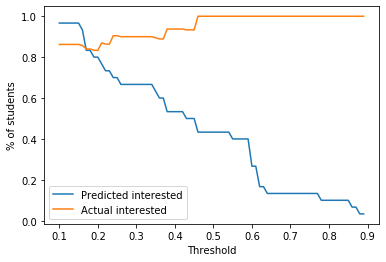

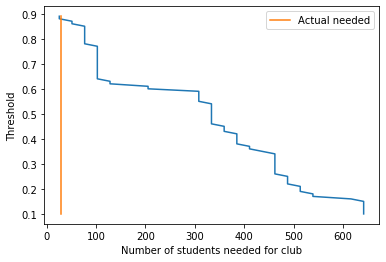

In [28]:
import matplotlib.pyplot as plt

#Plot for predicted vs actual number of people
plt.plot(thres, pred_interested, label = "Predicted interested")
plt.plot(thres, precision, label = "Actual interested")
plt.xlabel('Threshold')
plt.ylabel('% of students')
plt.legend()
plt.show()


plt.plot(pred_attend, thres)
plt.plot( [30 for i in range(len(thres))] ,thres, label = "Actual needed")
plt.ylabel('Threshold')
plt.xlabel('Number of students needed for club')
plt.legend()
plt.show()

# Clustering our students with the important features. We want to get the characteristics of each cluster (with the highest rate of Attendance)

In [20]:
cols_of_int = [var[0] for var in coeff_list if var[1] != 0 and var[0] != 'pos' and var[0] != 'Interest category_No interest or no exposure ']
cluster_df = X[cols_of_int]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
cluster_df['Participation in art activities'] = scaler.fit_transform(cluster_df['Participation in art activities'].values.reshape(-1, 1)) #0 to 3
cluster_df['Career oriented'] = scaler.fit_transform(cluster_df['Career oriented'].values.reshape(-1, 1)) #0 to 3


cols_of_int

C:\Users\Junrong\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Junrong\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


['Previous Arts CCA_Performance',
 'Previous Arts CCA_Sculpture',
 'Year_Year 2',
 'Participation in art activities',
 'Career oriented',
 'Year_Year 1',
 'School_School of Accountancy',
 'School_School of Economics']

In [21]:
from sklearn.cluster import KMeans

K = range(5,10)
inertias = [] 
mapping1 = {} 

for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(cluster_df)  
    inertias.append(kmeanModel.inertia_) 
    mapping1[k] = kmeanModel.inertia_ 

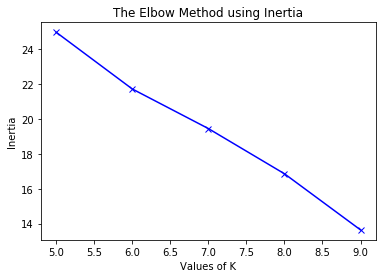

In [22]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

#### We will set out k=8

In [23]:
kmeans = KMeans(n_clusters=8, random_state=0).fit(cluster_df)
cluster_df['cluster'] = kmeans.labels_
cluster_df

C:\Users\Junrong\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Previous Arts CCA_Performance,Previous Arts CCA_Sculpture,Year_Year 2,Participation in art activities,Career oriented,Year_Year 1,School_School of Accountancy,School_School of Economics,cluster
0,0,0,0,0.000000,0.666667,0,0,0,6
1,0,0,0,0.666667,1.000000,0,0,0,1
2,0,0,1,0.000000,0.000000,0,0,0,0
3,0,0,1,0.000000,0.666667,0,0,0,0
4,0,1,1,0.666667,0.666667,0,0,0,0
...,...,...,...,...,...,...,...,...,...
68,1,0,0,0.333333,0.666667,0,0,0,3
69,0,0,0,1.000000,0.666667,0,0,0,1
70,0,0,0,0.000000,0.333333,0,0,0,6
71,0,0,0,0.000000,0.666667,0,0,1,4


#### Exploring the clusters with highest attendance rates

In [24]:
cluster_df['Attendance'] = df['Attendance']
cluster_df.groupby('cluster').agg({'Attendance':'mean'}).reset_index().sort_values(by='Attendance',ascending=False)

C:\Users\Junrong\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,cluster,Attendance
3,3,1.000000
7,7,1.000000
1,1,0.900000
0,0,0.880000
6,6,0.833333
4,4,0.666667
5,5,0.666667
2,2,0.500000


In [25]:
cluster_df[cluster_df['cluster']==3]

,Previous Arts CCA_Performance,Previous Arts CCA_Sculpture,Year_Year 2,Participation in art activities,Career oriented,Year_Year 1,School_School of Accountancy,School_School of Economics,cluster,Attendance
8,1,0,0,0.666667,0.333333,0,0,0,3,1
56,1,0,0,0.666667,0.333333,0,0,0,3,1
61,1,0,0,0.000000,0.333333,0,0,0,3,1
62,1,0,0,0.666667,0.000000,0,0,0,3,1
63,1,0,0,0.333333,0.666667,0,0,0,3,1
68,1,0,0,0.333333,0.666667,0,0,0,3,1


In [26]:
cluster_df[cluster_df['cluster']==7]

,Previous Arts CCA_Performance,Previous Arts CCA_Sculpture,Year_Year 2,Participation in art activities,Career oriented,Year_Year 1,School_School of Accountancy,School_School of Economics,cluster,Attendance
7,1,0,0,0.333333,0.333333,1,1,0,7,1
13,1,0,0,0.000000,0.333333,1,0,0,7,1
24,1,0,0,0.000000,0.333333,1,1,0,7,1
28,1,0,0,0.000000,0.333333,1,0,0,7,1
49,1,0,0,1.000000,0.000000,1,0,0,7,1


In [27]:
cluster6_df = cluster_df[cluster_df['cluster']==3]
ideal_df = cluster6_df.groupby('cluster').agg({'Previous Arts CCA_Performance':lambda x : x.mode(),
                                    'Previous Arts CCA_Sculpture':lambda x : x.mode(),
                                    'Year_Year 2':lambda x : x.mode(),
                                    'Year_Year 1':lambda x : x.mode(),
                                    'School_School of Accountancy':lambda x : x.mode(),
                                    'School_School of Economics':lambda x : x.mode(),
                                    'Participation in art activities':'mean',
                                   'Career oriented' : 'mean'})
ideal_df

,Previous Arts CCA_Performance,Previous Arts CCA_Sculpture,Year_Year 2,Year_Year 1,School_School of Accountancy,School_School of Economics,Participation in art activities,Career oriented
cluster,,,,,,,,
3,1,0,0,0,0,0,0.444444,0.388889


In [28]:
linkedin_df = pd.read_csv('Linkedin_features_extracted.csv')
linkedin_df.shape[0]

770

In [29]:
from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')

In [30]:
converted_df = linkedin_df[['School_School of Accountancy','School_School of Economics','Year_Year 1','Year_Year 2','Participation in art activities','Previous Arts CCA_Performance','Career oriented']].T
converted_df.columns = linkedin_df['id'].tolist()

In [31]:
from scipy.sparse import csr_matrix
converted_mat = csr_matrix(converted_df.values)

In [32]:
model_knn.fit(linkedin_df[['School_School of Accountancy','School_School of Economics','Year_Year 1','Year_Year 2','Participation in art activities','Previous Arts CCA_Performance','Career oriented']])

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [33]:
linkedin_df['cosine_distance'] = 1
for i in [3,7,1,0,6]:
    cluster6_df = cluster_df[cluster_df['cluster']==i]
    ideal_df = cluster6_df.groupby('cluster').agg({'Previous Arts CCA_Performance':lambda x : x.mode(),
                                        'Previous Arts CCA_Sculpture':lambda x : x.mode(),
                                        'Year_Year 2':lambda x : x.mode(),
                                        'Year_Year 1':lambda x : x.mode(),
                                        'School_School of Accountancy':lambda x : x.mode(),
                                        'School_School of Economics':lambda x : x.mode(),
                                        'Participation in art activities':'mean',
                                       'Career oriented' : 'mean'})

    scores, index = model_knn.kneighbors(ideal_df[['School_School of Accountancy','School_School of Economics','Year_Year 1','Year_Year 2','Participation in art activities','Previous Arts CCA_Performance','Career oriented']],n_neighbors=10)
    linkedin_df['cosine_distance'].loc[index.tolist()[0]] = scores.tolist()[0]

C:\Users\Junrong\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Junrong\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Junrong\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

In [34]:
linkedin_df[linkedin_df['cosine_distance'] != 1].to_csv('linkedin_Candidates.csv')

In [39]:
cluster6_df = cluster_df[cluster_df['cluster']==7]
ideal_df = cluster6_df.groupby('cluster').agg({'Previous Arts CCA_Performance':lambda x : x.mode(),
                                    'Previous Arts CCA_Sculpture':lambda x : x.mode(),
                                    'Year_Year 2':lambda x : x.mode(),
                                    'Year_Year 1':lambda x : x.mode(),
                                    'School_School of Accountancy':lambda x : x.mode(),
                                    'School_School of Economics':lambda x : x.mode(),
                                    'Participation in art activities':'mean',
                                   'Career oriented' : 'mean'})
ideal_df

,Previous Arts CCA_Performance,Previous Arts CCA_Sculpture,Year_Year 2,Year_Year 1,School_School of Accountancy,School_School of Economics,Participation in art activities,Career oriented
cluster,,,,,,,,
7,1,0,0,1,0,0,0.266667,0.266667
